In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error as mse

In [2]:
def plot_prices(df, cols, *add_lines):
    plt.figure(figsize = (18, 9))
    
    for col in cols:
        plt.plot(df[col], label = col)
    
    if add_lines:
        for line in add_lines:
            plt.plot(line)
    
    plt.xticks(df.index[::500], rotation=45)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Price', fontsize=18)
    plt.legend(fontsize=18)
    plt.show()

# Data import

In [3]:
df = pd.read_csv('data/NFLX.csv')
df.sort_values('Date', inplace=True)

df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

date_range = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
df = df.reindex(date_range)
df.ffill(inplace=True)

In [4]:
df['Mid'] = (df['Low'] + df['High']) / 2.0
df.head()

,Open,High,Low,Close,Adj Close,Volume,Mid
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0,1.194285
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.211072
2002-05-25,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.211072
2002-05-26,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.211072
2002-05-27,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.211072


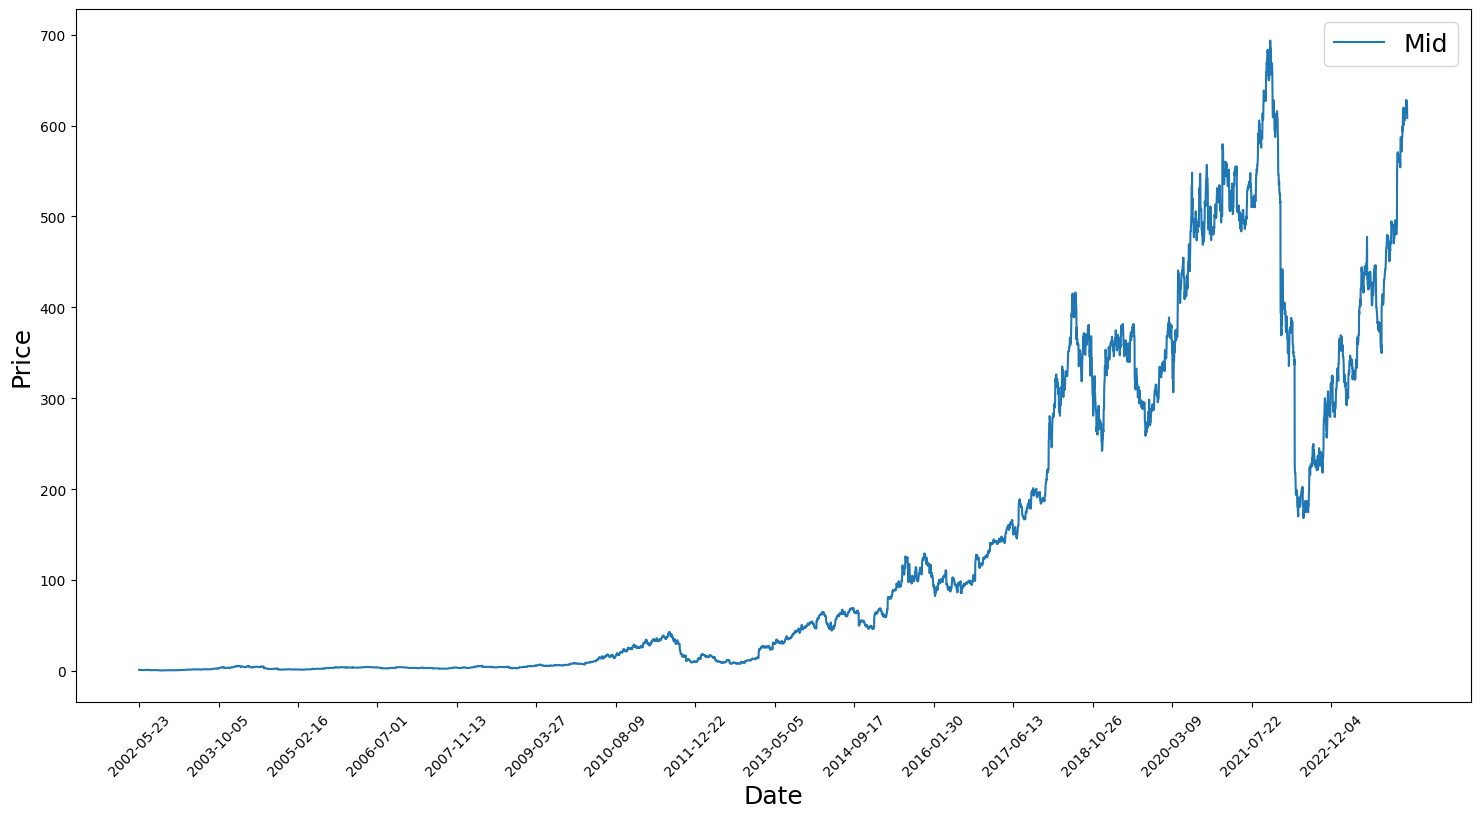

In [5]:
plot_prices(df, ['Mid'])

# Creating training and testing dataframes

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

In [7]:
scaler = MinMaxScaler()

window_size = 1000
train_scaled = np.zeros_like(train_df[['Mid']])

for i in range(0, train_df.shape[0], window_size):
    window = train_df[['Mid']][i: i + window_size]
    train_scaled[i: i + window_size] = scaler.fit_transform(window)
    
train_df['Scaled'] = train_scaled
test_df['Scaled'] = scaler.transform(test_df[['Mid']])
df['Scaled'] = pd.concat([train_df['Scaled'], test_df['Scaled']])

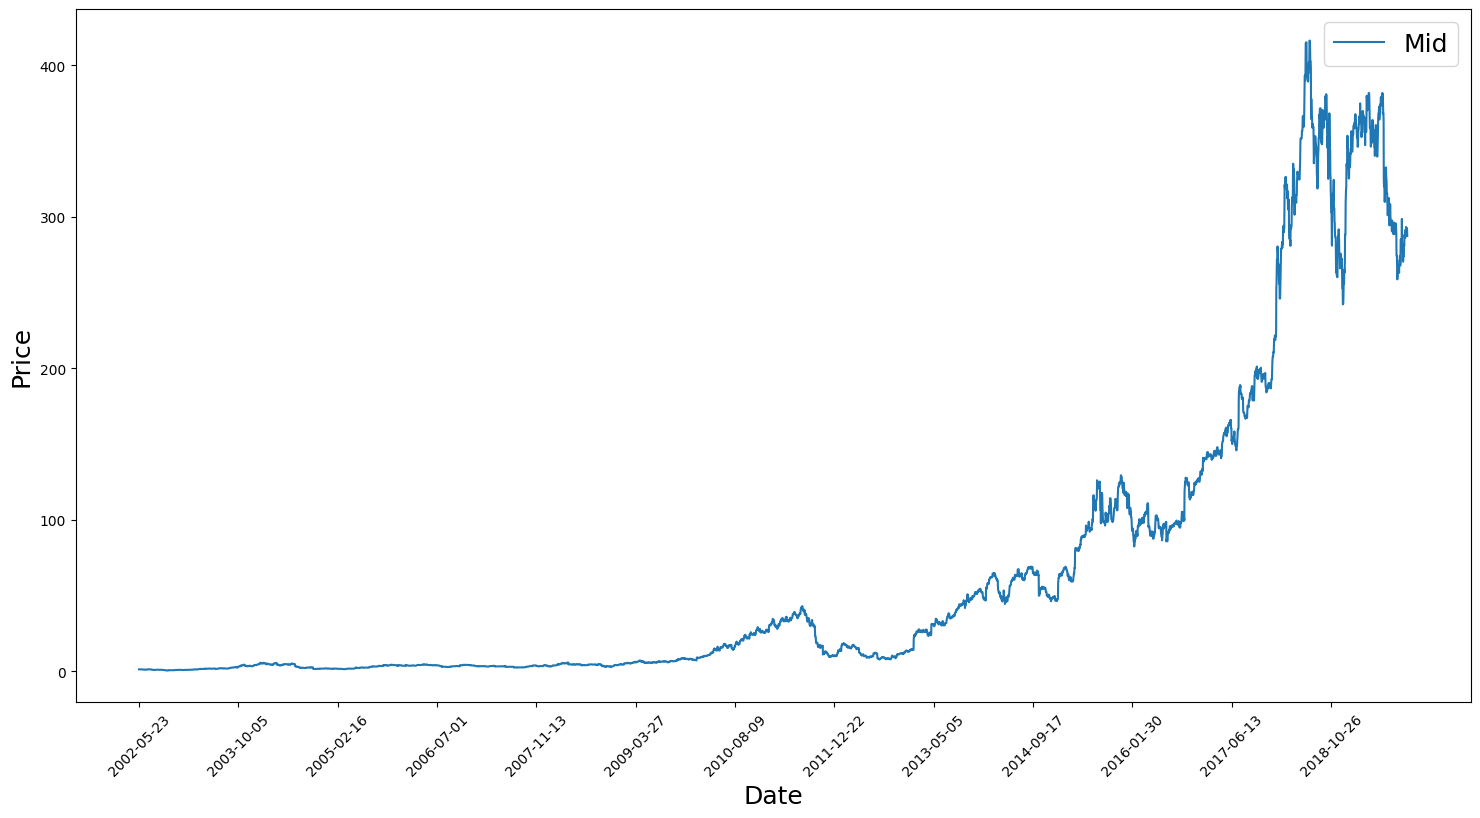

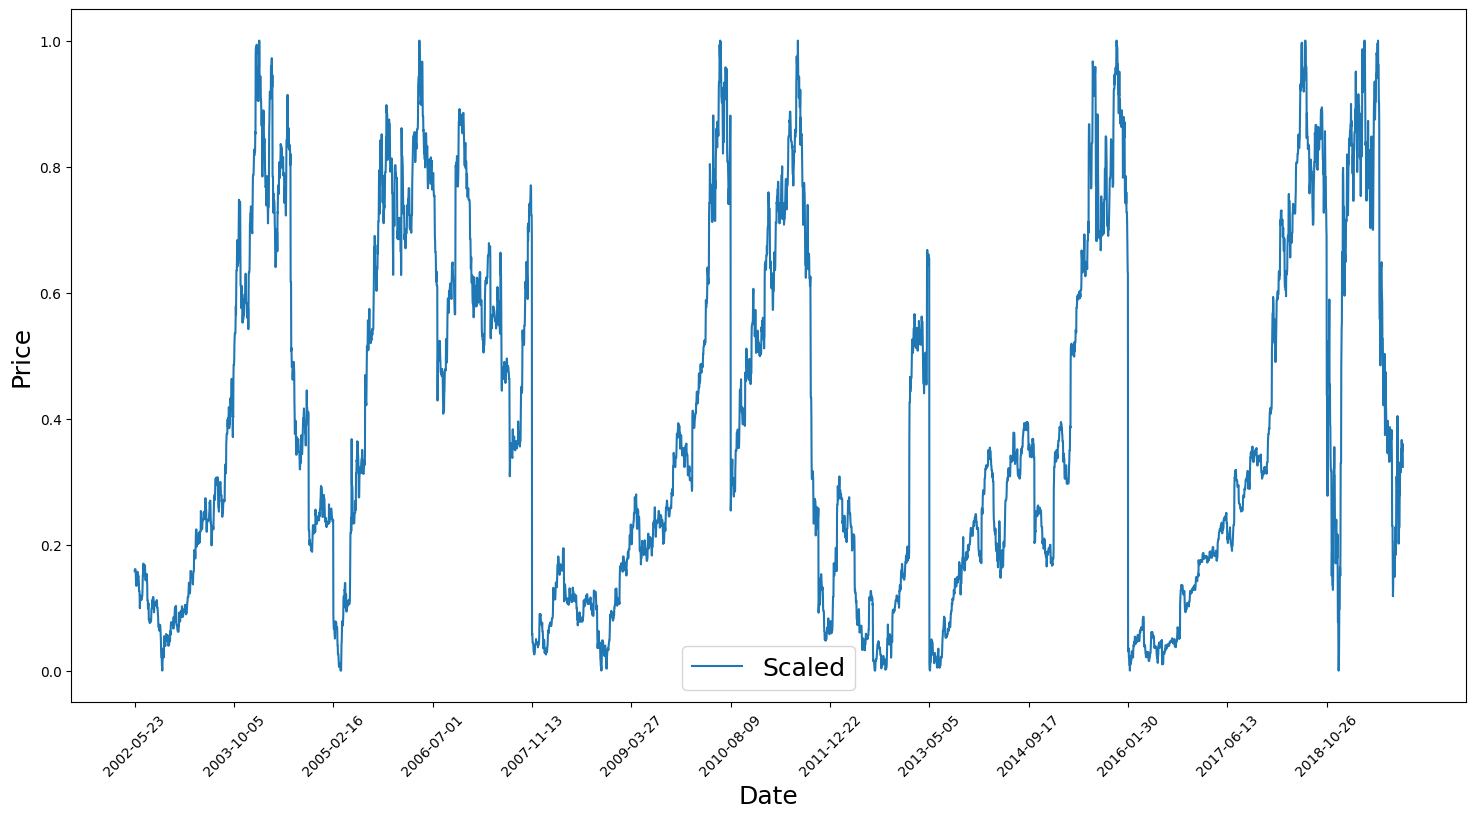

In [8]:
plot_prices(train_df, ['Mid'])
plot_prices(train_df, ['Scaled'])

In [9]:
train_df['Smoothed'] = train_df['Scaled'].ewm(com=0.5).mean()
train_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Mid,Scaled,Smoothed
2019-11-09,288.730011,293.989990,287.510010,291.570007,291.570007,4509000.0,290.750000,0.348267,0.348979
2019-11-10,288.730011,293.989990,287.510010,291.570007,291.570007,4509000.0,290.750000,0.348267,0.348505
2019-11-11,289.160004,296.359985,288.500000,294.179993,294.179993,3944300.0,292.429993,0.360310,0.356375
2019-11-12,295.320007,295.350006,288.700012,292.010010,292.010010,5772800.0,292.025009,0.357407,0.357063
2019-11-13,291.029999,293.410004,281.140015,283.109985,283.109985,9158900.0,287.275010,0.323358,0.334593


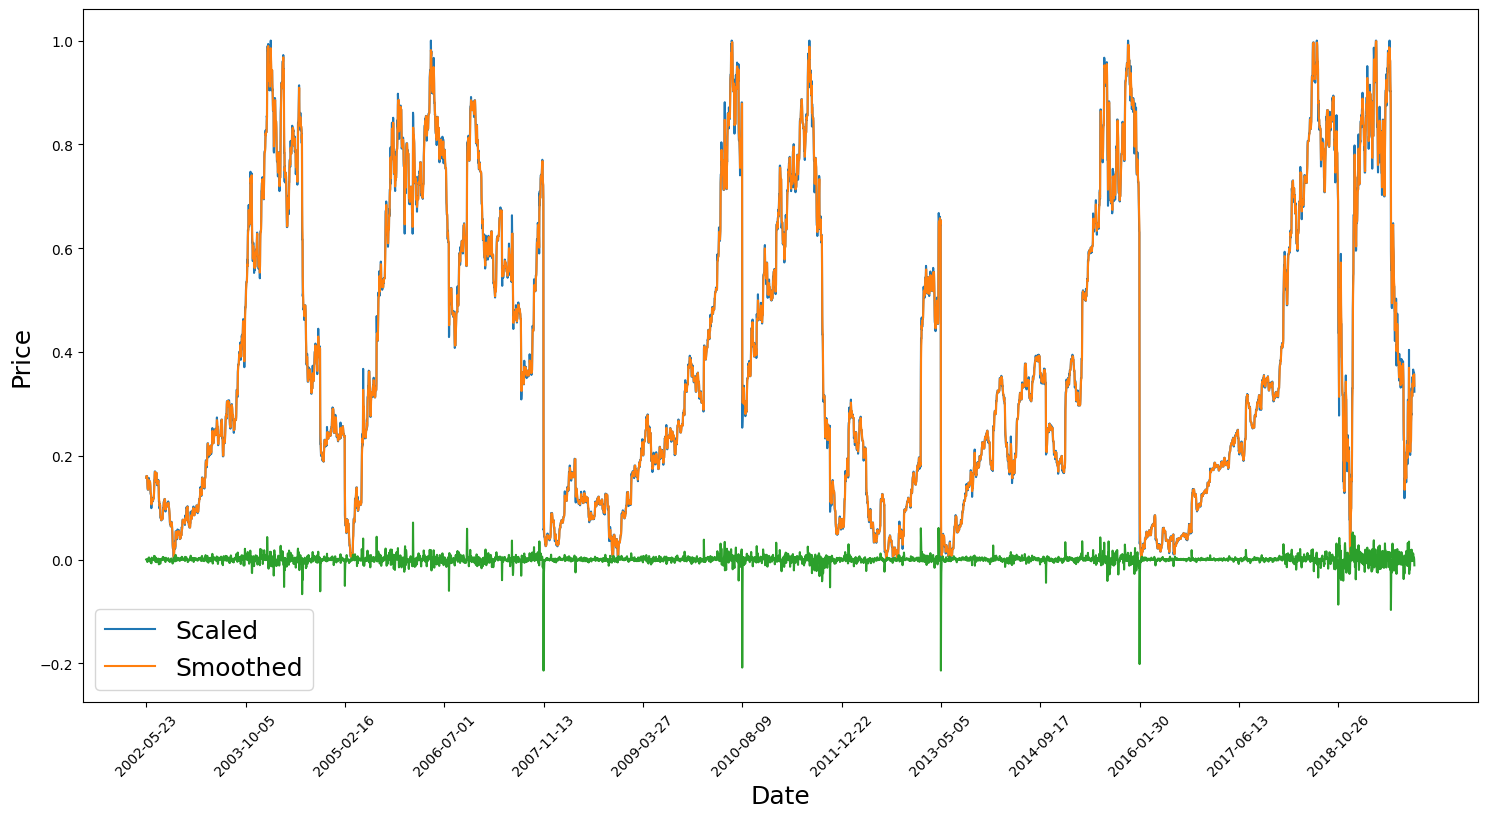

In [10]:
plot_prices(train_df, ['Scaled', 'Smoothed'], train_df['Scaled']-train_df['Smoothed'])

# Naive models

## SMA - Standard Moving Average

In [11]:
window_size = 100

sma_predictions = []
sma_date = []

for i in range(window_size, train_df.shape[0]):
    sma_date.append(train_df.index[i])
    sma_predictions.append(np.mean(train_df[['Smoothed']][i - window_size: i]))

sma_mse = mse(train_df['Smoothed'][window_size:], sma_predictions)

sma_df = pd.DataFrame({'Date': sma_date, 'Prediction': sma_predictions})
sma_df.set_index('Date', inplace=True)

print(f'MSE of Standard Moving Average Model: {sma_mse:.5f}')

MSE of Standard Moving Average Model: 0.02475


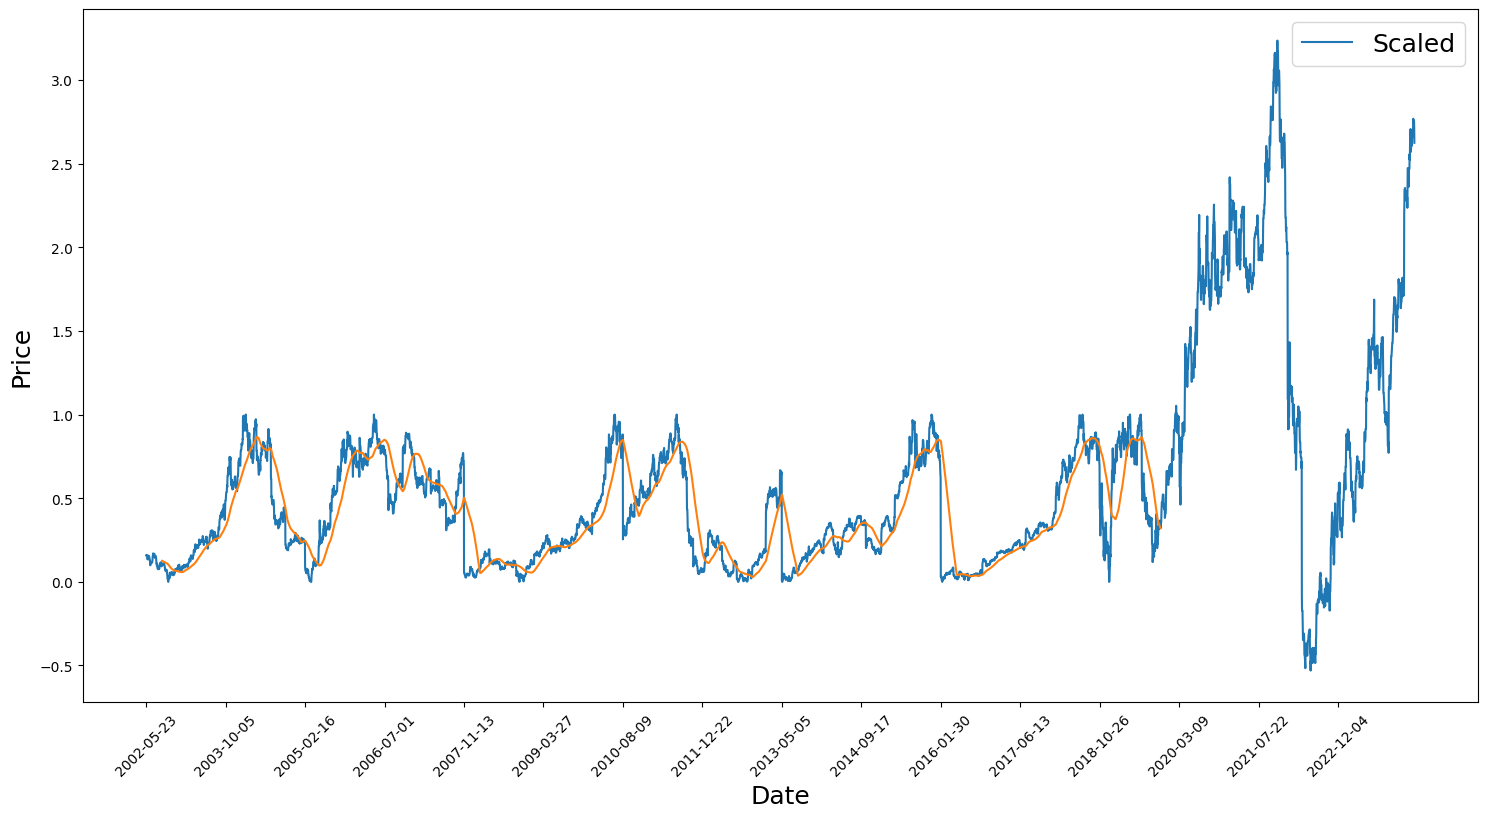

In [12]:
plot_prices(df, ['Scaled'], sma_df['Prediction'])

## EMA - Exponential Moving Average

In [13]:
window_size = 100

ema_predictions = []
ema_date = []

running_mean = 0.0
ema_predictions.append(running_mean)
ema_date.append(train_df.index[0])

decay = 0.5

for i in range(1, train_df.shape[0]):
    ema_date.append(train_df.index[i])
    
    running_mean = running_mean * decay + train_df['Smoothed'].iloc[i-1] * (1 - decay)
    ema_predictions.append(running_mean)

ema_mse = mse(train_df['Smoothed'], ema_predictions)

ema_df = pd.DataFrame({'Date': ema_date, 'Prediction': ema_predictions})
ema_df.set_index('Date', inplace=True)

print(f'MSE of Exponential Moving Average Model: {ema_mse:.5f}')

MSE of Exponential Moving Average Model: 0.00065


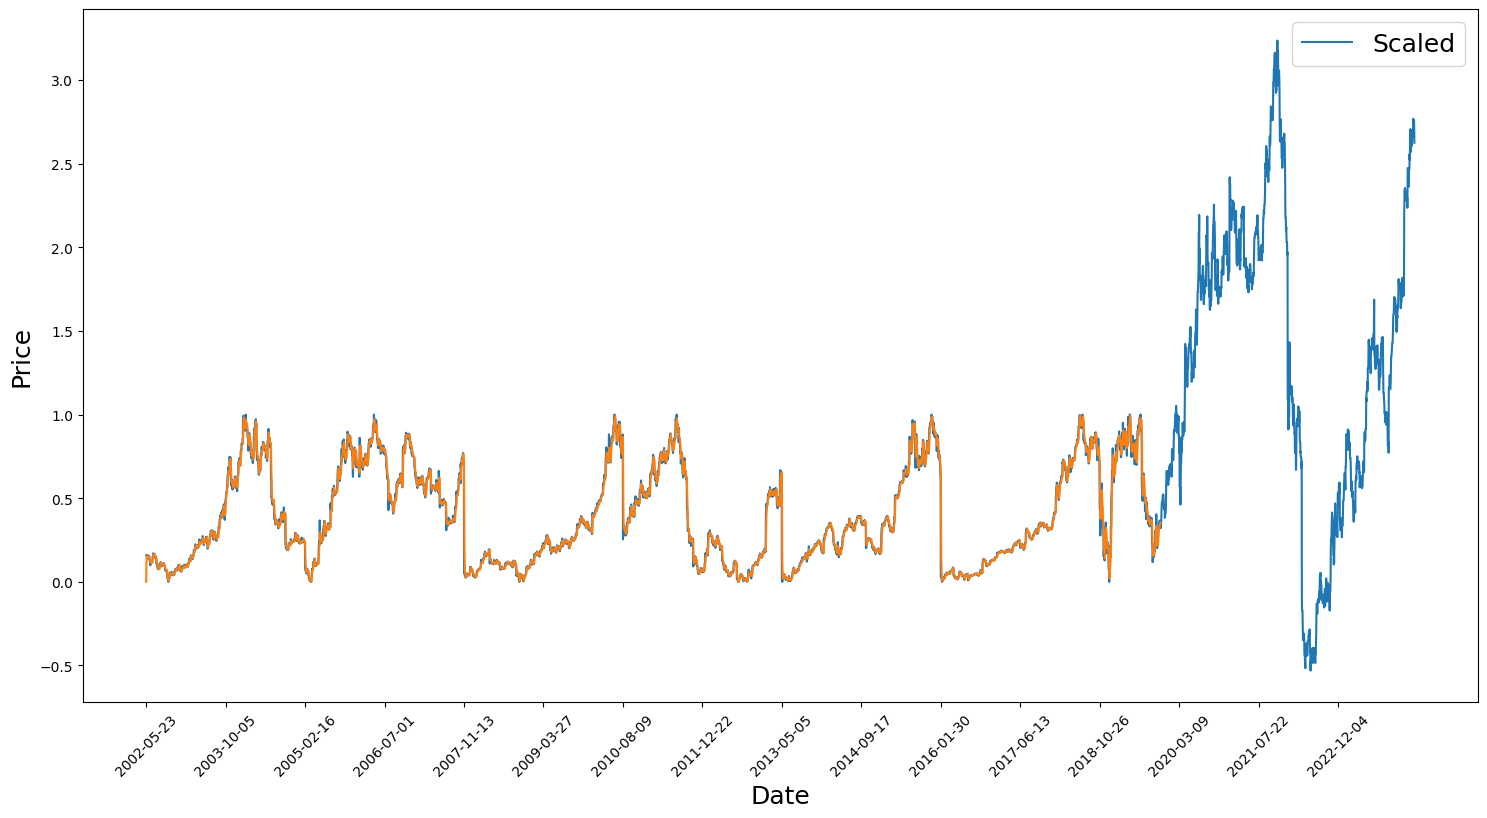

In [14]:
plot_prices(df, ['Scaled'], ema_df['Prediction'])